# Satellite Lake Water Temperature

This dataset provides mid-morning daily lake surface water temperature (LSWT) values derived from satellite data, along with associated uncertainty and quality levels. The data, retrieved from ATSR and AVHRR sensors, have been bias-adjusted for consistency and may contain gaps due to missing observations. LSWT is an essential climate variable critical for understanding lake ecology, hydrological processes, and large-scale climate interactions, with data development supported by the UK NERC GloboLakes project and future enhancements from the ESA Climate Change Initiative.

**Information on Dataset:**
* Source: [Satellite Lake Water Temperature](https://cds.climate.copernicus.eu/datasets/satellite-lake-water-temperature?tab=overview)
* Author:
* Notebook Version: 1.3 (Updated: December 03, 2024)

## 1. Specifying the paths and working directories

In [1]:
import os

''' ---- Hier die Verzeichnisse angeben ---- '''
download_folder = r".\data\satellite-lake-water-temperature\download"
working_folder = r".\data\satellite-lake-water-temperature\working"
geotiff_folder = r".\data\satellite-lake-water-temperature\geotiff"
csv_folder = r".\data\satellite-lake-water-temperature\csv"
output_folder = r".\data\satellite-lake-water-temperature\output"
''' ----- Ende der Eingaben ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Download and Extract Dataset

### 2.1 Authentication

In [2]:
import cdsapi

def main():
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Request Definition and Download

In [3]:
# Define additional request fields to ensure the request stays within the file size limit.
# These coordinates were obtained using the BBox Extractor tool: https://str-ucture.github.io/bbox-extractor/

bbox_wgs84_constance = [48.0, 8.7, 47.3, 9.9]  # [North, West, South, East]

# Different data versions are available depending on the year of interest.
year = 2007
version = "4_5_1" if year <= 2020 else "4_5_2"

In [4]:
dataset = "satellite-lake-water-temperature"
request = {
    "variable": "all",
    "year": [f"{year}"],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "version": version,
    "area": bbox_wgs84_constance
}

In [5]:
# Uncomment and run this cell to download the dataset:

def main_retrieve():
    dataset_filename = f"{dataset}_{request['year'][0]}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)
    
    # Download the dataset only if the dataset has not been downloaded before
    if not os.path.isfile(dataset_filepath):
        # Download the dataset with the defined request parameters
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Dataset already downloaded.")
        
if __name__ == "__main__":
    client = main()
    main_retrieve()

2024-12-12 15:03:15,175 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.


2024-12-12 15:03:15,198 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


2024-12-12 15:03:15,198 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**


2024-12-12 15:03:15,199 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


Dataset already downloaded.


### 2.3 Extract the Zip folder

In [6]:
import zipfile

# Construct the dataset filename and path
dataset_filename = f"{dataset}_{year}.zip"
dataset_filepath = os.path.join(download_folder, dataset_filename)
extract_folder = os.path.join(working_folder, str(year))

# Extract the zip file
try:
    os.makedirs(extract_folder, exist_ok=True)
    
    if not os.listdir(extract_folder):
        with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Successfully extracted files to: {extract_folder}")
    else:
        print("Folder is not empty. Skipping extraction.")
except FileNotFoundError:
    print(f"Error: The file {dataset_filepath} was not found.")
except zipfile.BadZipFile:
    print(f"Error: The file {dataset_filepath} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Folder is not empty. Skipping extraction.


## 3. Merge NetCDF4 Files into a Single NetCDF4 File
Dataset is available for all 365days (366days for leap year) for each year
> Important: Daily dataset may have sparse or no data. Hence, merged netCDF file may comtain empty daily data

In [7]:
import xarray as xr

# Filter the list of filenames
nc_filepath_merged = os.path.join(output_folder,f"{dataset}_{year}.nc")

if not os.path.isfile(nc_filepath_merged):
    filename_list = os.listdir(extract_folder)

    # Load all NetCDF files into a list of datasets
    datasets = [xr.open_dataset(os.path.join(extract_folder, f)) for f in filename_list]
    merged_dataset = xr.concat(datasets, dim='time')

    # Save the merged dataset into a new NetCDF file
    merged_dataset.to_netcdf(nc_filepath_merged)
    print(f"New NetCDF4 file created at {nc_filepath_merged} for year {year}")
else:
    print(f"{nc_filepath_merged} already exists.")

.\data\satellite-lake-water-temperature\output\satellite-lake-water-temperature_2007.nc already exists.


## 4. Read the merged netCDF4 file and print the metadata

In [8]:
import netCDF4 as nc

# Open the NetCDF file in read mode
nc_filename = f"satellite-lake-water-temperature_{year}.nc"
nc_filepath = os.path.join(output_folder, nc_filename)

# Open the NetCDF file in read mode
nc_dataset = nc.Dataset(nc_filepath_merged, mode="r")

# List all variables in the dataset
variables_list = nc_dataset.variables.keys()
print(f"Available variables: {list(variables_list)}")

Available variables: ['lake_surface_water_temperature', 'lswt_uncertainty', 'lswt_quality_level', 'lswt_obs_instr', 'lswt_flag_bias_correction', 'lakeid_CCI', 'lakeid_GloboLakes', 'lat', 'lon', 'time']


In [9]:
import pandas as pd

# Define variable name from available variables and read variable data
variable_name = 'lake_surface_water_temperature'
variable_data = nc_dataset[variable_name]

# Generate summary of the primary variable
summary = {
    "Variable Name": variable_name,
    "Data Type": variable_data.dtype,
    "Shape": variable_data.shape,
    "Variable Info": f"{variable_name}({', '.join(variable_data.dimensions)})",
    "Units": getattr(variable_data, "units", "N/A"),
    "Long Name": getattr(variable_data, "long_name", "N/A"),
}

# Display dataset summary as a DataFrame for better visualization
nc_summary = pd.DataFrame(list(summary.items()), columns=['Description', 'Remarks'])

# Display the summary DataFrame
nc_summary

,Description,Remarks
0,Variable Name,lake_surface_water_temperature
1,Data Type,int16
2,Shape,"(365, 14, 24)"
3,Variable Info,"lake_surface_water_temperature(time, lat, lon)"
4,Units,kelvin
5,Long Name,lake surface skin water temperature


## 4. Export Dataset to CSV

### 4.1 Compute Daily Average and Export as CSV

In [10]:
import netCDF4 as nc
import pandas as pd
from datetime import datetime
import numpy as np

def netcdf_to_dataframe(nc_file):
    # Open the dataset
    with nc.Dataset(nc_file, "r") as nc_dataset:
        # Extract and decode time variable
        time_var = nc_dataset.variables["time"]
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)

        # Extract and calculate temperature values
        temperature_data = nc_dataset.variables["lake_surface_water_temperature"][:]
        temperature_data_units = nc_dataset.variables["lake_surface_water_temperature"].units
        temperature_mean_list = np.nanmean(temperature_data, axis=(1, 2))
        temperature_std_list = np.nanstd(temperature_data, axis=(1, 2))
        
        # Counts the number of valid (non-NaN) pixels per day in the dataset
        # Daily dataset may have sparse or no data on some days.
        nonzero_count_list = np.count_nonzero(~np.isnan(temperature_data), axis=(1,2))

        lswt_uncertainty = nc_dataset.variables["lswt_uncertainty"][:]
        lswt_uncertainty_units = nc_dataset.variables["lswt_uncertainty"].units
        # lswt_uncertainty_mean_list = np.nanmean(lswt_uncertainty, axis=(1, 2))
        # Error propagation for uncertainty of mean temperature
        lswt_uncertainty_squared = np.nanmean(lswt_uncertainty**2, axis=(1, 2))
        lswt_mean_uncertainty = np.sqrt(lswt_uncertainty_squared)
        
        lswt_quality_level = nc_dataset.variables["lswt_quality_level"][:]
        lswt_quality_level_mean_list = np.nanmean(lswt_quality_level, axis=(1, 2))

        # Create DataFrame
        df = pd.DataFrame(
            {
                "Time": cftime,
                f"Mean Temperature ({temperature_data_units[0].capitalize()})": temperature_mean_list,
                "Std Dev": temperature_std_list,
                f"Uncertainty ({lswt_uncertainty_units[0].capitalize()})": lswt_mean_uncertainty,
                f"Mean Quality Level": lswt_quality_level_mean_list,
                "Non-Zero Count":nonzero_count_list,
            }
        )
        return df
    
# Modify display format for numbers in the DataFrames
pd.options.display.float_format = '{:,.2f}'.format

# Generate DataFrame (".dropna(): filters with NaN values)
df = netcdf_to_dataframe(nc_filepath_merged)
filtered_df = netcdf_to_dataframe(nc_filepath_merged).dropna().reset_index(drop=True)

# Generate the output file path
csv_filename = f"satellite-lake-water-temperature_daily-mean-{year}.csv"
csv_filepath = os.path.join(csv_folder, csv_filename)

# Export the filtered data to a CSV file if it doesn't already exist
if not os.path.isfile(csv_filepath):
    filtered_df.to_csv(csv_filepath, index=False)
    print(f"Filtered data exported successfully to {csv_filepath}")
else:
    print(f"File already exists at {csv_filepath}. Skipping export.")

# Display the filtered DataFrame
filtered_df.head()

File already exists at .\data\satellite-lake-water-temperature\csv\satellite-lake-water-temperature_daily-mean-2007.csv. Skipping export.


,Time,Mean Temperature (K),Std Dev,Uncertainty (K),Mean Quality Level,Non-Zero Count
0,2007-01-02 12:00:00,278.46,0.11,0.43,4.86,7.00
1,2007-01-05 12:00:00,275.98,0.58,0.29,3.60,5.00
2,2007-01-06 12:00:00,278.64,0.00,0.34,4.00,1.00
3,2007-01-11 12:00:00,277.96,1.43,0.18,3.14,7.00
4,2007-01-14 12:00:00,278.68,0.76,0.19,4.30,20.00


### 4.2 Plot Daily Average
> Note: Due to limited daily/monthly data for 2023 dataset, **Plots** do not work properly

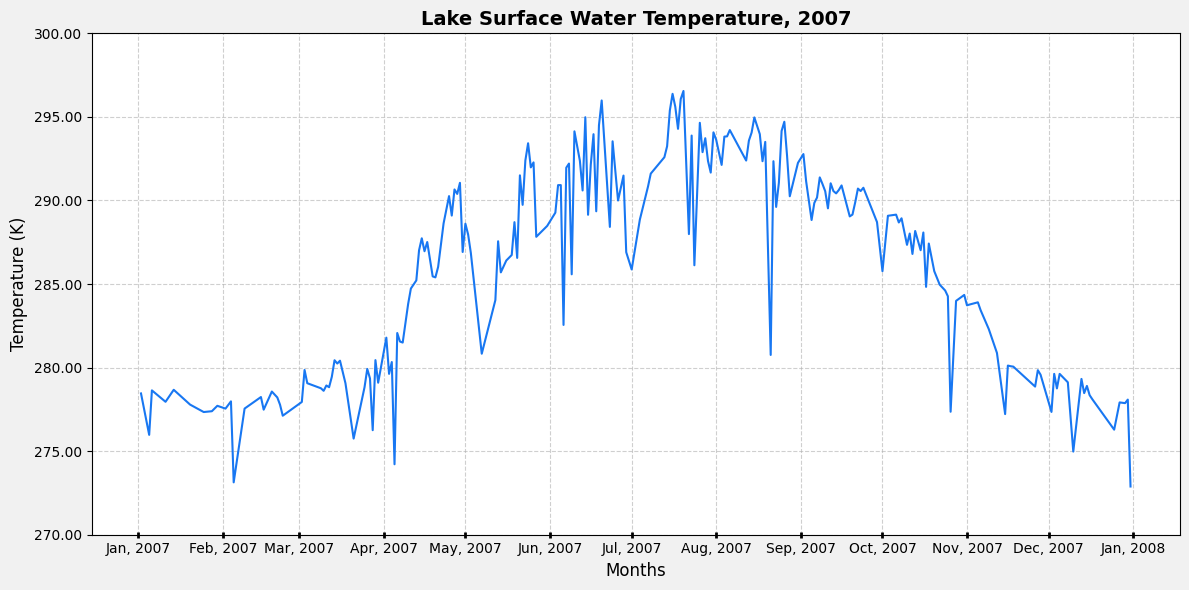

In [11]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator 
import matplotlib.ticker as ticker
import math

# Prepare df for plot
filtered_df_copy = filtered_df.copy()
filtered_df_copy['Date'] = [t.strftime('%Y-%m-%d') for t in filtered_df['Time']]
filtered_df_copy['Date'] = [datetime.strptime(d, '%Y-%m-%d').date() for d in filtered_df_copy['Date']]
vmax = math.ceil(filtered_df_copy['Mean Temperature (K)'].max() / 10) * 10
vmin = math.floor(filtered_df_copy['Mean Temperature (K)'].min() / 10) * 10

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

# Plot the data
ax.plot(filtered_df_copy['Date'],
        filtered_df_copy['Mean Temperature (K)'],
        # marker='o',
        # markersize=3.0,
        linestyle='-',
        color='#1877F2',
        label="Surface Water Temperature",
        )

# Format the axis
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b, %Y'))
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2)
ax.tick_params(axis='x', which='minor', length=3, direction='inout')

# Set y-axis limit
ax.set_ylim(vmin, vmax)

# Set axis labels and title
ax.set_xlabel('Months', fontsize=12)
ax.set_ylabel('Temperature (K)', fontsize=12)
ax.set_title(f'Lake Surface Water Temperature, {year}', fontsize=14, fontweight='bold')

# Add grid
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### 4.3 Plot Monthly Average

In [12]:
# Prepare data for plot
# Uncertainty calculated using error propagation
filtered_df_monthly = (
    filtered_df_copy.groupby(pd.PeriodIndex(filtered_df_copy["Date"], freq="M"))[[
        "Mean Temperature (K)", "Std Dev", "Uncertainty (K)", "Mean Quality Level"
    ]]
    .agg({
        "Mean Temperature (K)": "mean",
        "Std Dev": lambda x: (x**2).mean()**0.5,
        "Uncertainty (K)": lambda x: (x**2).mean()**0.5,
        "Mean Quality Level": "mean"
    })
    .reset_index()
)

filtered_df_monthly['Date'] = filtered_df_monthly['Date'].dt.to_timestamp()

# Generate the output file path
csv_filename = f"satellite-lake-water-temperature_monthly-mean-{year}.csv"
csv_monthly_means = csv_filepath = os.path.join(csv_folder, "monthly means")
os.makedirs(csv_monthly_means, exist_ok=True)
csv_filepath = os.path.join(csv_monthly_means, csv_filename)

# Export the filtered data to a CSV file if it doesn't already exist
if not os.path.isfile(csv_filepath):
    filtered_df.to_csv(csv_filepath, index=False)
    print(f"Monthly means exported successfully to {csv_filepath}")
else:
    print(f"File already exists at {csv_filepath}. Skipping export.")

filtered_df_monthly.head()

File already exists at .\data\satellite-lake-water-temperature\csv\monthly means\satellite-lake-water-temperature_monthly-mean-2007.csv. Skipping export.


,Date,Mean Temperature (K),Std Dev,Uncertainty (K),Mean Quality Level
0,2007-01-01,277.77,0.63,0.31,4.16
1,2007-02-01,277.36,0.35,0.23,4.14
2,2007-03-01,279.02,1.16,0.28,3.70
3,2007-04-01,285.22,1.27,0.27,3.41
4,2007-05-01,288.30,1.75,0.42,3.28


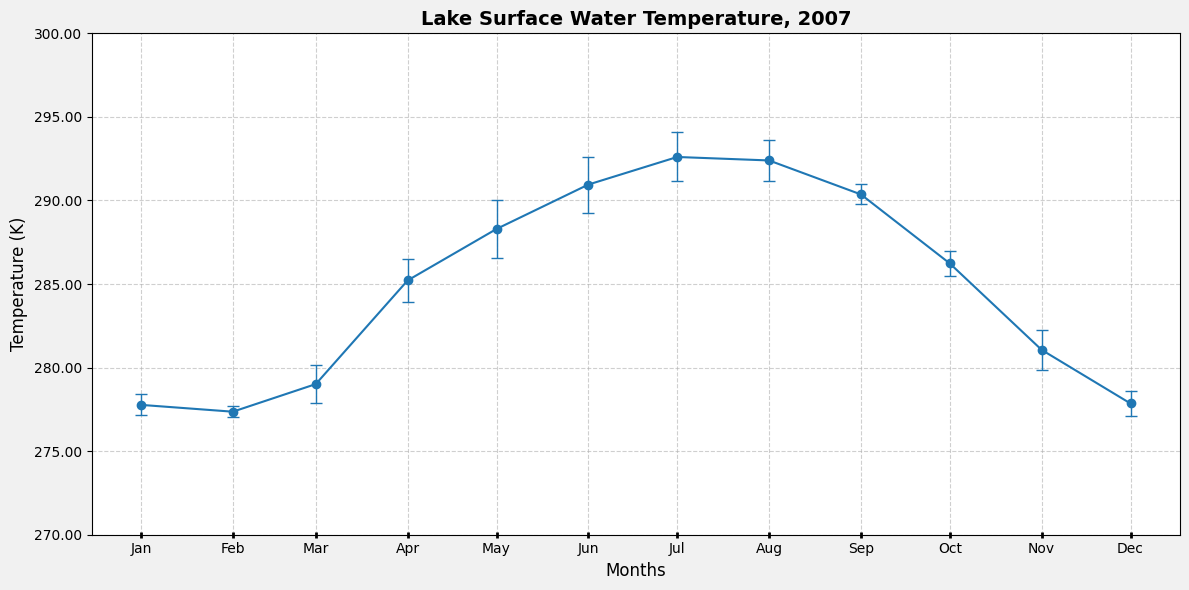

In [13]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')

# Plot the data
ax.errorbar(
    filtered_df_monthly['Date'],
    filtered_df_monthly['Mean Temperature (K)'],
    yerr=filtered_df_monthly['Std Dev'],
    fmt='o-',
    label='Mean Temperature ± Uncertainty',
    capsize=4,
    elinewidth=1,
    capthick=1,
)

# Format the axis
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b'))
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2) 
ax.tick_params(axis='x', which='minor', length=3, direction='inout') 

# Set y-axis limit
ax.set_ylim(vmin, vmax)

# Set axis labels and title
ax.set_xlabel('Months', fontsize=12)
ax.set_ylabel('Temperature (K)', fontsize=12)
ax.set_title(f'Lake Surface Water Temperature, {year}', fontsize=14, fontweight='bold')

# Add grid
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

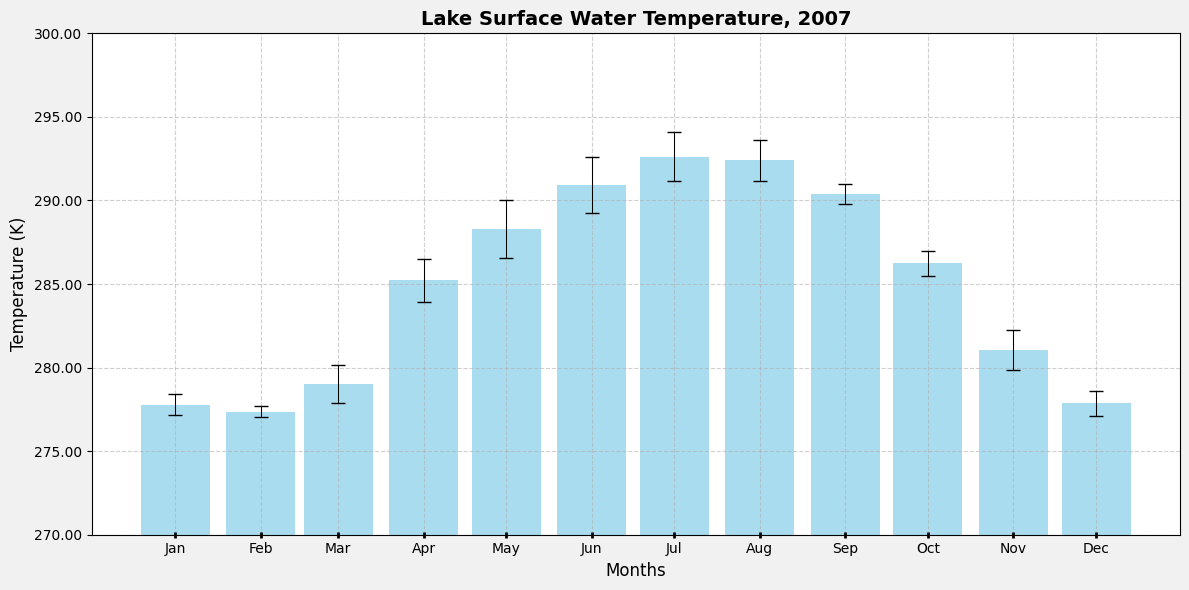

In [14]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f1f1f1', edgecolor='k')


# Plot the data
ax.bar(filtered_df_monthly['Date'],
       filtered_df_monthly['Mean Temperature (K)'],
       yerr=filtered_df_monthly['Std Dev'],
       color='skyblue',
       alpha=0.7,
       width=25,
       label='Mean Temperature ± Uncertainty',
       capsize=5,
       error_kw=dict(ecolor='black', lw=0.75),
       )

# Format the axis
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b'))
ax.tick_params(axis='x', which='major', length=4, direction='inout', width=2) 
ax.tick_params(axis='x', which='minor', length=3, direction='inout') 

# Set y-axis limit
ax.set_ylim(vmin, vmax)

# Set axis labels and title
ax.set_xlabel('Months', fontsize=12)
ax.set_ylabel('Temperature (K)', fontsize=12)
ax.set_title(f'Lake Surface Water Temperature, {year}', fontsize=14, fontweight='bold')

# Add grid
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## 5. Export merged netCDF4 file to GeoTIFF

### 5.1 Export All-Year Dataset as Merged GeoTIFF File

In [15]:
import rasterio
from rasterio.transform import from_origin
import netCDF4 as nc
from tqdm import tqdm

def main_export_geotiff(nc_file):
    # Open the NetCDF dataset and read variable data
    nc_dataset = nc.Dataset(nc_file, mode='r')
    temperature_data = nc_dataset[variable_name]
    
    # Extract time variable and convert it to readable dates
    time_var = nc_dataset.variables['time']
    time_units = nc_dataset.variables['time'].units
    time_calendar = getattr(time_var, "calendar", "standard")
    cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
    
    # Compute spatial resolution and raster transformation
    lat = nc_dataset['lat'][:]
    lon = nc_dataset['lon'][:]
    
    pixel_size_lat = (lat.max() - lat.min()) / (len(lat) - 1)
    pixel_size_lon = (lon.max() - lon.min()) / (len(lon) - 1)
    transform = from_origin(lon.min() - pixel_size_lon / 2,
                            lat.min() - pixel_size_lat / 2,
                            pixel_size_lon,
                            -pixel_size_lat
                            )
    
    # Create a merged GeoTIFF containing all time slices as separate bands
    output_filename = f"{variable_name}_{year}_merged.tif"
    output_folder = os.path.join(geotiff_folder, "merged_geotiff")
    os.makedirs(output_folder, exist_ok=True)
    output_filepath = os.path.join(output_folder, output_filename)

    # Create a GeoTIFF with multiple bands for each time slice
    with rasterio.open(
        output_filepath,
        "w",
        driver = "GTiff",
        dtype = str(temperature_data.dtype),
        width = temperature_data.shape[2],
        height = temperature_data.shape[1],
        count = temperature_data.shape[0],
        crs = "EPSG:4326",
        nodata = -9999,
        transform=transform,        
    ) as dst:
        for year_index in tqdm(range(temperature_data.shape[0]), desc=f"Exporting merged GeoTIFF file for {year}"):
            band_data = temperature_data[year_index,:,:]
            dt = cftime[year_index]
            band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"
            
            # Write each year slice as a band
            dst.write(band_data, year_index + 1)
            dst.set_band_description(year_index + 1, band_desc)

year = 2008
nc_filename_merged = f"satellite-lake-water-temperature_{year}.nc"
nc_filepath_merged = os.path.join(output_folder, nc_filename)
variable_name = 'lake_surface_water_temperature'

main_export_geotiff(nc_filepath_merged)


Exporting merged GeoTIFF file for 2008:   0%|                                                                                                                                                                    | 0/365 [00:00<?, ?it/s]

Exporting merged GeoTIFF file for 2008:  37%|████████████████████████████████████████████████████████▋                                                                                               | 136/365 [00:00<00:00, 1357.64it/s]

Exporting merged GeoTIFF file for 2008:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 272/365 [00:00<00:00, 1157.66it/s]

Exporting merged GeoTIFF file for 2008: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [00:00<00:00, 1161.27it/s]

In [16]:
# import rasterio
# from rasterio.transform import from_origin
# import netCDF4 as nc

# first_band = 0
# last_band = 363
# bands_to_export = range(first_band, last_band + 1)
# variable_name = 'lake_surface_water_temperature'
# output_file = r"G:/lake_surface_water_temperature_merged.tif"

# # read
# dataset = nc.Dataset(nc_filepath_merged, mode='r')

# temperature = dataset[variable_name][:]
# lon_list = dataset['lon'][:]
# lat_list = dataset['lat'][:]
# time_var = dataset.variables['time']
# time_units = dataset.variables['time'].units
# time_calendar = getattr(time_var, "calendar", "standard")
# cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)

# # transform
# pixel_size_lat = (lat_list.max() - lat_list.min()) / (len(lat_list) - 1)
# pixel_size_lon = (lon_list.max() - lon_list.min()) / (len(lon_list) - 1)
# transform = from_origin(lon_list.min() - pixel_size_lon / 2,
#                         lat_list.min() - pixel_size_lat / 2,
#                         pixel_size_lon,
#                         -pixel_size_lat
#                         )

# ## Standard transform is
# # transform = from_origin(lon.min(), lat.max(), pixel_size_lon, pixel_size_lat)
# # followed by 90deg rotation and flipping
# # However, this creates geotiff that is shifted by half pixel right and half pixel down

# # subset
# temperature_subset = temperature[bands_to_export, :, :]
# cftime_subset = cftime[bands_to_export]

# # metadata for geotiff
# meta = {
#     "driver": "GTiff",
#     "dtype": str(temperature_subset.dtype),
#     "nodata": -9999,
#     "width": temperature_subset.shape[2],
#     "height": temperature_subset.shape[1],
#     "count": temperature_subset.shape[0],
#     "crs": "EPSG:4326",
#     "transform": transform,
# }

# with rasterio.open(output_file, "w", **meta) as dst:
#     for band in range(temperature_subset.shape[0]):
#         dst.write(temperature_subset[band, :, :], band + 1)
#         dst.set_band_description(band + 1, f"{cftime_subset[band]}")
        
# print(f"Merged GeoTIFF saved as {output_file}")

### 5.2 V2: From Tim

In [17]:
# import rasterio
# from rasterio.transform import from_origin
# from rasterio.crs import CRS
# import numpy as np
# from netCDF4 import num2date

# crs = CRS.from_epsg(4326)
# ds = nc.Dataset(nc_filepath_merged, 'r')

# lat = ds.variables['lat'][:]
# lon = ds.variables['lon'][:]
# time_var = ds.variables['time']
# time_units = ds.variables['time'].units

# pixel_size_lat = (lat.max() - lat.min()) / (len(lat) - 1)
# pixel_size_lon = (lon.max() - lon.min()) / (len(lon) - 1)
# transform = from_origin(lon.min(), lat.max(), pixel_size_lon, pixel_size_lat)

# unprocessed_dir = r"G:/"

# t = 341
# data = ds.variables[variable_name][t, :, :]
# data[data == data.fill_value] = -9999
# year = int(num2date(time_var[t], time_units).year)

# geotiff_path = os.path.join(unprocessed_dir, f'unprocessed.tiff')
# with rasterio.open(
#     geotiff_path,
#     'w',
#     driver='GTiff',
#     height=data.shape[0],
#     width=data.shape[1],
#     count=1,
#     dtype=data.dtype,
#     crs=crs,
#     transform=transform,
#     nodata=-9999
# ) as dst:
#     dst.write(data, 1)

# rotated_data = np.rot90(data, k=2)
# flipped_data = np.fliplr(rotated_data)

# processed_path = os.path.join(unprocessed_dir, f'processed.tiff')
# with rasterio.open(
#     processed_path,
#     'w',
#     driver='GTiff',
#     height=flipped_data.shape[0],
#     width=flipped_data.shape[1],
#     count=1,
#     dtype=flipped_data.dtype,
#     crs=crs,
#     transform=transform,
#     nodata=-9999
# ) as dst:
#     dst.write(flipped_data, 1)
# ds.close()

### 5.3 Plot using cmap

In [18]:
# max_value = df['Non-Zero Count'].max()
# rows_with_max_count = df.loc[df['Non-Zero Count'] == max_value]
# row_number = df.index.get_loc(df['Non-Zero Count'].idxmax())

# print(row_number)
# rows_with_max_count

In [19]:
# import geopandas as gpd
# from matplotlib.ticker import FuncFormatter
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# # Function to format latitude tick labels
# def format_latitude(x, pos):
#     return f"{x:.2f}°N"

# # Function to format longitude tick labels
# def format_longitude(x, pos):
#     return f"{x:.2f}°E"

# with nc.Dataset(nc_filepath_merged, "r") as dataset:
#     variable_data = dataset["lake_surface_water_temperature"]
        
#     band_data = variable_data[row_number, :, :] - 273.15
#     vmin = np.round(np.floor(np.nanmin(band_data)), 1)
#     vmax = np.round(np.ceil(np.nanmax(band_data)), 1)
#     bins = int((vmax-vmin)/0.25)
    
#     # Plot the data using matplotlib
#     fig, ax = plt.subplots(figsize=(8, 8))
    
#     # Load predefined colormap
#     cmap = plt.get_cmap("turbo", bins)
    
#     # Create a pseudo-color plot for the data
#     pcm = ax.pcolormesh(
#         lon_list,
#         lat_list,
#         band_data,
#         cmap=cmap,
#         vmin=vmin,
#         vmax=vmax
#     )
    
#     # Add administrative boundary of Konstanz (Shapefile)
#     konstanz_shp = r".\shapefiles\kn_boundary.shp"
#     konstanz_boundary = gpd.read_file(konstanz_shp)
#     konstanz_boundary.boundary.plot(ax=ax, edgecolor='red')
    
#     # Plot color bar
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="4%", pad=-1.1)
#     plt.colorbar(pcm, cax=cax, label=f'{summary["Long Name"]} (°C)')
    
#     # Add grid lines
#     ax.grid(visible=True, which='major', color='#5f5f5f', linestyle='--', alpha=0.5)
    
#     # Set custom tick formatters for latitude and longitude
#     ax.xaxis.set_major_formatter(FuncFormatter(format_longitude))
#     ax.yaxis.set_major_formatter(FuncFormatter(format_latitude))
    
#     ax.set_xlim(8.8,9.8)
#     ax.set_ylim(47.4,47.9)

#     ax.set_title(f'{(summary["Long Name"]).capitalize()} (°C)')
#     ax.set_ylabel('Latitude', fontsize=12)
#     ax.set_xlabel('Longitude', fontsize=12)

#     # Display the plot
#     plt.tight_layout()
#     plt.show()